## Dataloader

In [1]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.io as io
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import torchaudio
import torchaudio.transforms as AT

import lightning as L

import mediapipe as mp
from utils.vid2lm import landmarks_to_numpy


In [2]:
class MEAD(Dataset):
    def __init__(self, data_path, duration):
        super(MEAD, self).__init__()

        with open(data_path,"r") as f:
            self.datalist = json.load(f)
        self.time = duration


    def __len__(self):
        return len(self.datalist)
    
    def __getitem__(self, idx):
        row = self.datalist[idx]

        waveform, sample_rate = torchaudio.load(f"dataset/audios/{row['audio']}", num_frames= 48000* self.time, normalize="True")
        landmark =  torch.from_numpy(np.load(f"dataset/mp_landmarks/{row['landmark']}")).permute(2,0,1)[:,:30*self.time]
        # ilm = torch.mean(landmark, dim=1)
        ilm = landmark[:,-1,:]

        # waveform = torch.load(f"dataset/vec2s/M003_front_{row['name']}.pt")

        return {'name': row['name'], 'audio':waveform.float(), 'target':landmark.float(), 'ilm':ilm.float(), 'label':row['emotion']}

## Module


In [3]:
class S2LM(L.LightningModule):
    def __init__(self, batch, init_lr, duration):
        super(S2LM, self).__init__()

        self.init_lr = init_lr
        self.duration = 1
        self.batch = 4
        self.frame = 30*duration
        self.loss = nn.MSELoss()
        self.batch = batch


        self.conv = nn.Conv1d(in_channels=1, out_channels=self.frame, kernel_size=1)
        self.conv_m = nn.Conv1d(in_channels=1, out_channels=self.frame, kernel_size=1)
        # self.linear_in = nn.Linear(in_features=29, out_features=30)


        encoder_layer = nn.TransformerEncoderLayer(d_model=3200, nhead=2)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
        self.linear = nn.Linear(in_features=3200, out_features=956)
        decoder_layer = nn.TransformerDecoderLayer(d_model=956, nhead=2)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=12)

        self.linear_m = nn.Linear(in_features=956, out_features=160)
        decoder_layer_m = nn.TransformerDecoderLayer(d_model=160, nhead=2)
        self.transformer_decoder_m = nn.TransformerDecoder(decoder_layer_m, num_layers=12)

        self.linear_end = nn.Sequential(nn.Linear(in_features=956, out_features=1024), nn.ReLU(), nn.Linear(in_features=1024, out_features=956), nn.Sigmoid())
        self.linear_end_m = nn.Sequential(nn.Linear(in_features=160, out_features=256), nn.ReLU(), nn.Linear(in_features=256, out_features=160), nn.Sigmoid())
        self.linear_out = nn.Sequential(nn.Linear(in_features=478, out_features=1024), nn.ReLU(), nn.Linear(in_features=1024, out_features=478), nn.Sigmoid())


        self.MOUTH_LANDMARKS =[61, 76, 62, 185, 184, 183, 78, 77, 146, 191, 95, 96, 40, 74, 42, 80, 88, 89, 90, 91, 39, 73, 41, 81, 178, 179, 
                                180, 181, 37, 72, 38, 82, 87, 86, 85, 84, 0, 11, 12, 13, 14, 15, 16, 17, 267, 302, 268, 312, 317, 316, 315, 314,
                                    269, 303, 271, 311, 402, 403, 404, 405, 270, 304, 272, 310, 318, 319, 320, 321, 409, 408, 407, 415, 324, 325,
                                    307, 375, 308, 292, 306, 291]

    def forward(self, x, v, w=None):

        v_m = v[:,:,self.MOUTH_LANDMARKS]
        v = v.view(self.batch,1, -1)
        v = self.conv(v.float())

        # x = self.linear_in(x)
        x = x.view(self.batch, self.frame, -1)
        x = self.transformer_encoder(x)
        x = self.linear(x)
        x = torch.softmax(x,1)

        v_m = v_m.view(self.batch,1, -1)
        v_m = self.conv_m(v_m.float())

        x_m = self.linear_m(x)
        x_m = torch.softmax(x_m,1)
        x_m = self.transformer_decoder_m(x_m, v_m)
        x_m = self.linear_end_m(x_m)
        x_m = x_m.view(self.batch, 2, self.frame, -1)

        
        x = self.transformer_decoder(x, v)
        x = self.linear_end(x)
        x = x.view(self.batch, 2, self.frame, -1)
        x_t = x.clone()
        x_t[:,:,:,self.MOUTH_LANDMARKS] = x_m
        y = self.linear_out(x_t)

        return y
    
    def training_step(self, batch, batch_idx):
        x = batch['audio']
        y = batch['target']
        v = batch['ilm']
        y_ = self.forward(x, v, y)
        tt_loss = self.loss(y_.float()*256, y.float()*256)
        m_loss = self.loss(y[:,:,:,[self.MOUTH_LANDMARKS]].float()*256, y_[:,:,:,[self.MOUTH_LANDMARKS]].float()*256)
        loss = tt_loss*0.4 + m_loss*0.6
        # self.log('weighted', self.normalize_lr(), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x = batch['audio']
        y = batch['target']
        v = batch['ilm']

        y_ = self.forward(x,v )
        loss = self.loss(y_.float(), y.float())
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.init_lr)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=500, eta_min=0.0001)
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'  
        }

    def normalize_lr(self):
        current_lr = self.lr_schedulers().get_last_lr()[-1]
        eta_min = 0.0001
        initial_lr = self.init_lr

        return (current_lr - eta_min) / (initial_lr - eta_min)
    


    
datas = MEAD("dataset/datalist2.json", duration=1)
dataloader = DataLoader(datas, batch_size=4, shuffle=True,  num_workers=4)
model = S2LM(batch=4, init_lr=3e-4, duration=1)


In [4]:
from lightning import Trainer

# datas = MEAD("dataset/datalist2.json", duration=2)
# dataloader = DataLoader(datas, batch_size=4, shuffle=True, num_workers=4)
# model = S2LM(batch=4)

trainer = Trainer(accelerator='gpu', max_epochs=200, default_root_dir="./weights")
trainer.fit(model, dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                  | Type               | Params
--------------------------------------------------------------
0  | loss                  | MSELoss            | 0     
1  | conv                  | Conv1d             | 60    
2  | conv_m                | Conv1d             | 60    
3  | transformer_encoder   | TransformerEncoder | 324 M 
4  | linear                | Linear             | 3.1 M 
5  | transformer_decoder   | Transfo

Epoch 59:  67%|██████▋   | 4001/5998 [11:24<05:41,  5.85it/s, v_num=10, train_loss_step=77.50, train_loss_epoch=138.0]  

## Test


## Draw

In [5]:
model.to("cuda")
model.eval()
print()

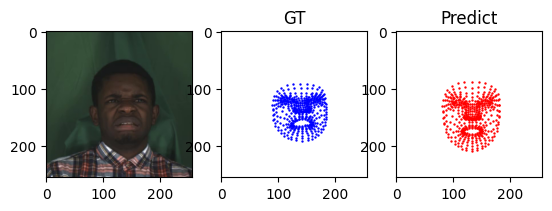

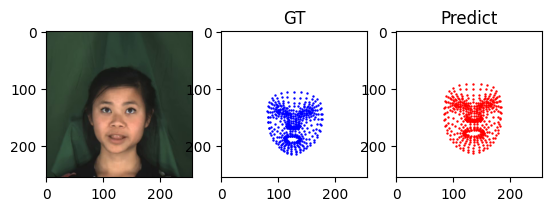

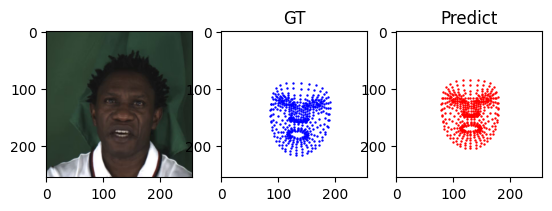

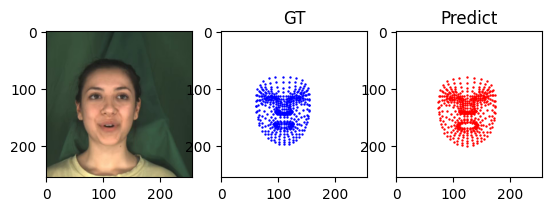

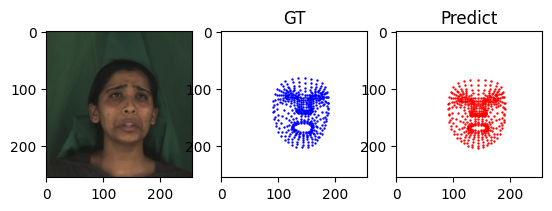

In [7]:
import torchvision
MOUTH_LANDMARKS =[61, 76, 62, 185, 184, 183, 78, 77, 146, 191, 95, 96, 40, 74, 42, 80, 88, 89, 90, 91, 39, 73, 41, 81, 178, 179, 
                               180, 181, 37, 72, 38, 82, 87, 86, 85, 84, 0, 11, 12, 13, 14, 15, 16, 17, 267, 302, 268, 312, 317, 316, 315, 314,
                                 269, 303, 271, 311, 402, 403, 404, 405, 270, 304, 272, 310, 318, 319, 320, 321, 409, 408, 407, 415, 324, 325,
                                   307, 375, 308, 292, 306, 291]

for i in range(5):
    item = next(iter(dataloader))
    x = item['audio'].to("cuda")
    v = item['ilm'].to("cuda")
    y = item['target'].to("cuda")
    video = torchvision.io.read_video(f"dataset/vidcrops/{item['name'][0]}.mp4")

    y_ = model.forward(x,v)
    y0 = y_[0].detach().cpu().numpy()
    y1 = y[0].detach().cpu().numpy()
    plain = np.ones((256,256,3))
    v = v.detach().cpu().numpy()
    plt.subplot(1,3,1)
    plt.imshow(video[0][0])
    plt.subplot(1,3,2)
    plt.imshow(plain)
    plt.scatter(v[0,0,:]*256, v[0,1:]*256, c='b', s=0.5)
    plt.title("GT")
    plt.subplot(1,3,3)
    plt.imshow(plain)
    plt.scatter(y0[0,0,:]*256, y0[1,0,:]*256, c='r', s=0.5)
    plt.title("Predict")
    plt.show()


In [8]:
import subprocess


for item in range(30):
    y0 = y_[0,:,item,:].detach().cpu().numpy()
    y1 = y[0,:,item,:].detach().cpu().numpy()

    plt.subplot(1,3,1)
    plt.imshow(video[0][item])
    plt.subplot(1,3,2)
    plt.imshow(plain)
    plt.scatter(y1[0,:]*256, y1[1,:]*256, c='b', s=0.5)
    plt.title("GT")
    plt.subplot(1,3,3)
    plt.imshow(plain)
    plt.scatter(y0[0,:]*256, y0[1,:]*256, c='r', s=0.5)
    plt.title("Predict")
    plt.savefig(f"temp/out_temp/{item}.png")
    plt.close()


image_folder = 'temp/out_temp'  # Replace with your folder path
video_name = 'temp/out_temp/video.mp4'

command = ['ffmpeg', '-i', f'{image_folder}/%d.png', video_name, '-y']
subprocess.run(command)

print(f"Video created: {video_name}")

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Video created: temp/out_temp/video.mp4


frame=   30 fps=0.0 q=-1.0 Lsize=      55kB time=00:00:01.08 bitrate= 413.7kbits/s speed=9.35x    
video:53kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 2.263032%
[libx264 @ 0x55880bfe6940] frame I:1     Avg QP:13.19  size: 11537
[libx264 @ 0x55880bfe6940] frame P:8     Avg QP:17.58  size:  2377
[libx264 @ 0x55880bfe6940] frame B:21    Avg QP:23.27  size:  1113
[libx264 @ 0x55880bfe6940] consecutive B-frames:  6.7%  0.0%  0.0% 93.3%
[libx264 @ 0x55880bfe6940] mb I  I16..4: 41.1% 46.8% 12.2%
[libx264 @ 0x55880bfe6940] mb P  I16..4:  0.2%  0.3%  0.0%  P16..4:  2.4%  1.5%  1.8%  0.0%  0.0%    skip:93.8%
[libx264 @ 0x55880bfe6940] mb B  I16..4:  0.0%  0.1%  0.0%  B16..8:  2.9%  0.7%  0.9%  direct: 0.4%  skip:95.0%  L0:49.4% L1:43.8% BI: 6.8%
[libx264 @ 0x55880bfe6940] 8x8 transform intra:48.5% inter:16.9%
[libx264 @ 0x55880bfe6940] coded y,u,v intra: 11.6% 4.5% 4.8% inter: 1.9% 0.8% 0.9%
[libx264 @ 0x55880bfe6940] i16 v,h,dc,p: 84% 15%  1%  1%
[libx264 @ 0

## Analysis

In [ ]:
datas = MEAD("dataset/all.json", duration=1)

In [ ]:
datalist = []
for item in datas:
    datalist.append({"name":item['name'],"audio":item['audio'].shape, "landmark":item['target'].shape})

In [ ]:
df = pd.DataFrame(datalist)
y_values = [item[1]/48000 for item in df['audio']]


Text(0.5, 1.0, 'Frequency amount of duration')

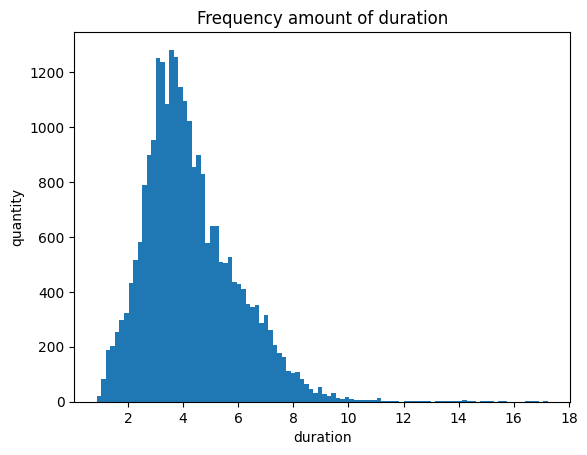

In [ ]:
plt.hist(df["duration"], bins=100)
plt.xlabel('duration')
plt.ylabel('quantity')
plt.title("Frequency amount of duration")